# Machine Design Project

This is a jupyter notebook outlining the design process (up to bearing selection)


In [115]:
import numpy as np

def show(*vars, format_spec = ".3f"):
    for var in vars:
        name = [k for k, v in globals().items() if v is var]
        if name:
            if isinstance(var, tuple) or isinstance(var, list):
                formatted_list = [f'{item:{format_spec}}' for item in var]
                print(f'{name[0]} = {formatted_list}')
            else:
                print(f'{name[0]} = {var:{format_spec}}')
        else:
            print('Variable not found')



## Power Transmission

Assumptions:

- The input gear is reffered to as _Gear 2_, and the output gear is reffered to as _Gear 3_

Knowns:

- One-stage gear reduction
- Input power of 9.5 HP
- Input speed of 3000 rpm
- Output speed of 400 $\pm$ 1% rpm
- Helical gears with helix angle $\psi = 30\degree$ and a normal pressure angle $\phi_n = 20\degree$

Find:

- Gear ratio
- Number of teeth on each gear
- Actual speed of each gear and shaft
- Torque on each gear and shaft

### Analysis

The range of acceptable output speeds is 400 $\pm$ 1%, calculating this range:

In [116]:
input_speed = 3000
output_speed = 400

output_speed_range = (output_speed - output_speed*0.01, output_speed + output_speed*0.01)

show(output_speed_range)

output_speed_range = ['396.000', '404.000']


We can find the speed ratio $e$ using the input and output speeds with equation 18-2.

$$ e = \frac{\omega_3}{\omega_2} \tag{18-2} $$

In [117]:
e = output_speed/input_speed

show(e)

e = 0.133


Using $e$ we can calculate the minimum number of teeth in the pinion $N$ using Equation 13-22. This equation requires the gear ratio $m$, which is equal to $\frac{1}{e}$:

$$
N_P = \dfrac{2k \cos\psi}{(1 + 2m)\sin^2\phi_t}\left( m + \sqrt{m^2 + (1+2m)\sin^2\phi_t} \right) \tag{13-22}
$$

In this equation, $k = 1$ for full-depth teeth, and $\phi_t$ can be calculated using $\tan\phi_t = \frac{\tan\phi_n}{\cos\psi}$.


In [118]:
def helical_NP_equation(m, psi, phi_t, k=1):
    
    return ((2*k*np.cos(psi)) / ((1 + 2*m) * np.sin(phi_t)**2)) * (m + np.sqrt(m**2 + (1 + 2*m)*np.sin(phi_t)**2))

m = 1/e

psi = np.deg2rad(30)
phi_n = np.deg2rad(20)
phi_t = np.arctan(np.tan(phi_n)/np.cos(psi))

N_P = helical_NP_equation(m, psi, phi_t)

show(N_P)

N_P = 10.931


We round this value of $N_P$ up to the nearest integer number of teeth, and then multiply $N_P$ by the gear ratio to obtain the number of teeth in the gear $N_G$, which we then round down to the nearest integer. If the ratio between these integer number of teeth is results in an output speed within tolerance then we have found the number of needed teeth.

In [119]:
from math import ceil, floor

N_2 = ceil(N_P)
show(N_2)

N_G = m*N_2
show(N_G)

N_3 = floor(N_G)
show(N_3)

# Finding the actual speed ratio (inverse of actual gear ratio)
e_actual = N_2/N_3

output_speed_actual = e_actual * input_speed
show(e_actual, output_speed_actual)

print(f'Actual output in tolerance?: {output_speed_range[0] <= output_speed_actual <= output_speed_range[1]}')

N_2 = 11.000
N_G = 82.500
N_3 = 82.000
e_actual = 0.134
output_speed_actual = 402.439
Actual output in tolerance?: True


With the actual input and output speeds determined along with the gear tooth counts, we can calculate the torque applied to each shaft/gear.

$$
T = \frac{H}{\omega} \cdot 550\frac{\text{ft-lbf/s}}{\text{hp}} \cdot \frac{1 \text{rev}}{2\pi \text{rad}} \cdot 60\frac{\text{s}}{\text{min}} \cdot 12\frac{\text{in}}{\text{ft}}
$$

$$
\rightarrow T \text{(lbf in)} = \dfrac{396000 H}{2\pi \omega}
$$

In [120]:
from numpy import pi

H = 9.5

T_2 = (396000 * H)/(2*pi * input_speed)
T_3 = (396000 * H)/(2*pi * output_speed_actual)

show(T_2, T_3)

T_2 = 199.580
T_3 = 1487.780


## Gear Selection

Assumptions:

- Gear and pinion are made of the same material
- The quality number of the gears is $Q_v = 5$
- The overload factor is $K_o = 1$

Knowns:

- Maximum width of 15 inches with 1.5 inches for wall thickness and clearance.
- Pinion and gear to operate for 1000 hours at 90% reliability
- Commercial enclosed unit
- Uncrowned teeth
- Not adjusted at assembly or lapped
- Use $K_s = 1$ and $C_f = 1$
- Light shock load from engine and moderate shock load from wheels
- Safety factors against bending and wear are to be $S_F = S_H = 1.2$

Find:

- Diametral pitch of the gears
- Gear and pinion material
- Actual safety factors of material selection for gear and pinion

### Analysis

The first step is to find the diametral pitches $P$ of the gears. The minimum diametral pitch is constrained by the maximum size of the gearbox, $Y = 15$ in, and allotted space for clearances and wall thickness, $X = 1.5$ in. The total width $Y$ is:

$$ Y = d_2 + d_3 + 2/P + X $$

Where $2/P$ accounts for the addendums of the gear and pinion. We can substitute $d_i = N_i/P$ to get:

$$ Y = N_2/P + N_3/P + 2/P + X $$

$$ P_t = \dfrac{N_2 + N_3 + 2}{Y - X} \tag{18-3 ish}$$

In [121]:
max_gearbox_width = 15
clearances = 1.5
P_t = (N_2 + N_3 + 2)/(max_gearbox_width - clearances)

show(P_t)

# Finding the normal pitch
P_n = P_t/np.cos(psi)
show(P_n)

P_t = 7.037
P_n = 8.126


This gives us a minimum for $P$. __Table 13-2__ lists common values of $P_n$ (which is why $P_n$ was calculated before), we round up to the nearest value where we find...

In [122]:
P_n = 10 #teeth/inch
P_t = P_n * np.cos(psi)
show(P_t)

d_2 = N_2/P_t   # Lecture 27 slide 8
d_3 = N_3/P_t
show(d_2, d_3)

P_t = 8.660
d_2 = 1.270
d_3 = 9.469


In [123]:
Y = d_2 + d_3 + clearances + (2/P_t)
show(Y)

Y = 12.470



Next, we need to find the required strength of materials for both the pinion and gear, for both wear and bending, ie, $S_{tG}$, $S_{CG}$, $S_{tP}$, and $S_{CP}$. These can be found using the AGMA equations.

$$
\sigma = W^t K_o K_v K_s \dfrac{P_d}{F} \dfrac{K_m K_B}{J} \tag{14-15}
$$

$$
S_F = \dfrac{S_t Y_N / (K_T K_R)}{\sigma} \rightarrow S_t = \sigma\dfrac{S_F K_T K_R}{Y_N} \tag{14-17}
$$

$$
\sigma_C = C_p \sqrt{W^t K_o K_v K_s \frac{K_m}{d_p F} \frac{C_f}{I}} \tag{14-16}
$$

$$
S_H = \dfrac{S_C Z_N C_H / (K_T K_R)}{\sigma_C} \rightarrow S_C = \sigma_C\dfrac{S_H K_T K_R}{Z_N C_H} \tag{14-18}
$$

To start finding these, we begin by finding general terms for the gear and pinion: $V$, $W^t$, and $F$. 

In [124]:
# Finding pitch-line velocity from Equation 13-34
V = (pi * d_2 * input_speed)/12

show(V)

# Transmitted load via Equation 13-35
W_t = 33000 * (H/V)

show(W_t)

V = 997.590
W_t = 314.257


In [125]:
# F is typically 3 to 5 times the circular pitch. Assuming F is 4 times the pitch (via textbook). 

F = 4 * (pi / P_t)

show(F)

F = 1.451


In [126]:
# Assignment specifies that face widths are available in 0.25 inch increments, rounding to the closest face width we get:

F = 1.50

Now we just need to find the AGMA stuff. I'm going to do the factors that are the same between gear and pinion first.

In [127]:
# From assumptions and assignment description:
K_s = C_f = 1

# Light shock load and medium tire shock (Figure 14-17)
K_o = 1.50

In [128]:
from numpy import sqrt
# Calculating K_v
Q = 5

B = 0.25 * (12 - Q)**(2/3)
A = 50 + 56*(1 - B)

K_v = ((A + sqrt(V))/A)**B
show(K_v)

# Checking that V is within maximum pitch-line velocity
V_max = (A + (Q - 3))**2
show(V_max)
show(V)

K_v = 1.517
V_max = 3222.801
V = 997.590


We are below the maximum pitch-line velocity, so we don't need to change our $Q$.

In [129]:
# K_m calculation

C_mc = 1    # uncrowned
C_pf = (F/(10*d_2)) - 0.0375 + 0.0125*F #14-32
C_pm = 1    # Evenly spaced between bearings

A = 0.127
B = 0.0158
C = -0.930e-4
C_ma = A + B*F + C*F**2     # Commerical enclosed

C_e = 1     # Not adjusted or lapped

K_m = 1 + C_mc*(C_pf*C_pm + C_ma*C_e)

show(K_m)

K_m = 1.250


We can just assume $K_B = 1$ since we're not adjusting the rim thickness. Same with the temperature factor $K_T$, we're not accounting for higher temperatures.

In [130]:
K_B = K_T = 1

In [131]:
# Reliability calculation for K_R at 90% reliability
K_R = 0.85  # Table 14-10

The elastic coefficient $C_p$ depends on the materials selected for the gear and pinion, so we'll just assume that we're going to select a steel material for both gears, which results in:

In [132]:
C_p = 2300 # Table 14-8

The hardness ratio coefficient $C_H$ can be set equal to 1 because we're assuming the same material for both gear and pinion

In [133]:
C_H = 1

That's all of the coefficients that are the same between both gears. Now the different ones.

For the stress-cycle factors ($Y_N$ and $Z_N$) we first have to convert the desired life of the gears in hours to a desired life in revolutions, which is dependent on the speed of the gear:

$$ L_{rev,i} = L_{hours} \cdot 60\frac{\text{min}}{\text{h}} \cdot \omega_i $$

In [134]:
L_hours = 1000

L_2 = L_hours * 60 * input_speed
L_3 = L_hours * 60 * output_speed_actual

show(L_2, L_3, format_spec=".3e")

L_2 = 1.800e+08
L_3 = 2.415e+07


With these found we can use __Figure 14-14__ to find $Y_N$ and __14-15__ for $Z_N$

In [135]:
Y_N2 = 1.6831 * L_2**(-0.0323)
Z_N2 = 2.466 * L_2**(-0.056)

Y_N3 = 1.6831 * L_3**(-0.0323)
Z_N3 = 2.466 * L_3**(-0.056)

show(Y_N2, Z_N2, Y_N3, Z_N3)

Y_N2 = 0.911
Z_N2 = 0.851
Y_N3 = 0.972
Z_N3 = 0.952


Geometry $J$ factor. The "Further Guidance for the Project" file provides details on how to find $J$, so I'm going to follow those guidelines:

In [136]:
show(N_2, N_3)

N_2 = 11.000
N_3 = 82.000


In [137]:
# From figures 14-7 and 14-8:

# Pinion has 11 teeth meshing with 82 teeth on gear, using 20 tooth line on 14-7 and 75-tooth line on 14-8
J_prime_2 = 0.465
J_2 = J_prime_2 * 1.00

# Gear has 82 teeth meshing with 11 teeth on pinion, thus using 60 tooth line on 14-7 and 20 tooth line on 14-8
J_prime_3 = 0.54
J_3 = J_prime_3 * 0.945

show(J_2, J_3)

J_2 = 0.465
J_3 = 0.510


Surface strength geometry factor $I$. These use equations 14-21 through 14-26

In [138]:
# Get pitch radii
r_2 = d_2/2
r_3 = d_3/2

# Base circle pitch-radii (Eq 14-26)
rb_2 = r_2*np.cos(phi_t)
rb_3 = r_3*np.cos(phi_t)

# Addendum
a = 1/P_n

# Equation 14-25
Z = sqrt((r_2 + a)**2 - rb_2**2) + sqrt((r_3 + a)**2 - rb_3**2) - (r_2 + r_3)*np.sin(phi_t)

# Speed ratio (Eq 14-22)
m_G = N_3/N_2

# Equation 14-24
p_n = pi/P_n
p_N = p_n * np.cos(phi_n)

# Equation 14-21
m_N = p_N/(0.95 * Z)

# Equation 14-23 (External gears)
I = ((np.cos(phi_t) * np.sin(phi_t))/(2 * m_N)) * ((m_G)/(m_G + 1))

show(rb_2, rb_3, a, Z, m_N, I)

rb_2 = 0.585
rb_3 = 4.364
a = 0.100
Z = 0.443
m_N = 0.702
I = 0.224


That should be all of them, we can now calculate the required strengths for the pinion and gear in wear and bending using safety factors of 1.2.

In [139]:
S_F = S_H = 1.2

# Pinion calculations

sigma_2 = W_t * K_o * K_v * K_s * (P_t/F) * ((K_m * K_B)/J_2)
St_2 = sigma_2 * ((S_F * K_T * K_R)/Y_N2)

sigma_C2 = C_p * sqrt(W_t * K_o * K_v * K_s * (K_m/(d_2*F)) * (C_f/I))
SC_2 = sigma_C2 * ((S_H*K_T*K_R)/(Z_N2 * C_H))

show(St_2, SC_2, format_spec='.3e')

St_2 = 1.242e+04
SC_2 = 1.261e+05


In [140]:
# Gear calculations

sigma_3 = W_t * K_o * K_v * K_s * (P_t/F) * ((K_m * K_B)/J_3)
St_3 = sigma_3 * ((S_F * K_T * K_R)/Y_N3)

sigma_C3 = C_p * sqrt(W_t * K_o * K_v * K_s * (K_m/(d_2*F)) * (C_f/I))
SC_3 = sigma_C3 * ((S_H*K_T*K_R)/(Z_N3 * C_H))

show(St_3, SC_3, format_spec='.3e')

St_3 = 1.061e+04
SC_3 = 1.127e+05


The largest required strength is for the pinion, with $S_{C,req} = 98.9$ ksi and $S_{t,req} = 9.89$ ksi, so those strengths are what we'll look for in table __14-3__ and __14-6__. From these tables we choose Grade 1 Flame-hardened steel with $S_C = 170$ ksi and $S_t = 45$ ksi. This material works for both the gear and pinion.

We now need to find the acheived factors of safety.

In [141]:
S_t = 45e3
S_C = 170e3

# Using equation 14-17/18 with S_H = S_F = 1
S_F2 = (S_t * Y_N2)/(sigma_2 * K_T * K_R)
S_H2 = (S_C * Z_N2 * C_H)/(sigma_C2 * K_T * K_R)

sigma_all2 = (S_t * Y_N2)/(1.2 * K_T * K_R)
sigma_Call2 = (S_C * Z_N2 * C_H)/(1.2 * K_T * K_R)

show(S_F2, S_H2, sigma_all2, sigma_Call2)

S_F2 = 4.347
S_H2 = 1.618
sigma_all2 = 40186.202
sigma_Call2 = 141757.668


In [142]:
S_F3 = (S_t * Y_N3)/(sigma_3 * K_T * K_R)
S_H3 = (S_C * Z_N3 * C_H)/(sigma_C3 * K_T * K_R)

sigma_all3 = (S_t * Y_N3)/(1.2 * K_T * K_R)
sigma_Call3 = (S_C * Z_N3 * C_H)/(1.2 * K_T * K_R)

show(S_F3, S_H3, sigma_all3, sigma_Call3)

S_F3 = 5.090
S_H3 = 1.811
sigma_all3 = 42880.137
sigma_Call3 = 158636.145


## Force Analysis
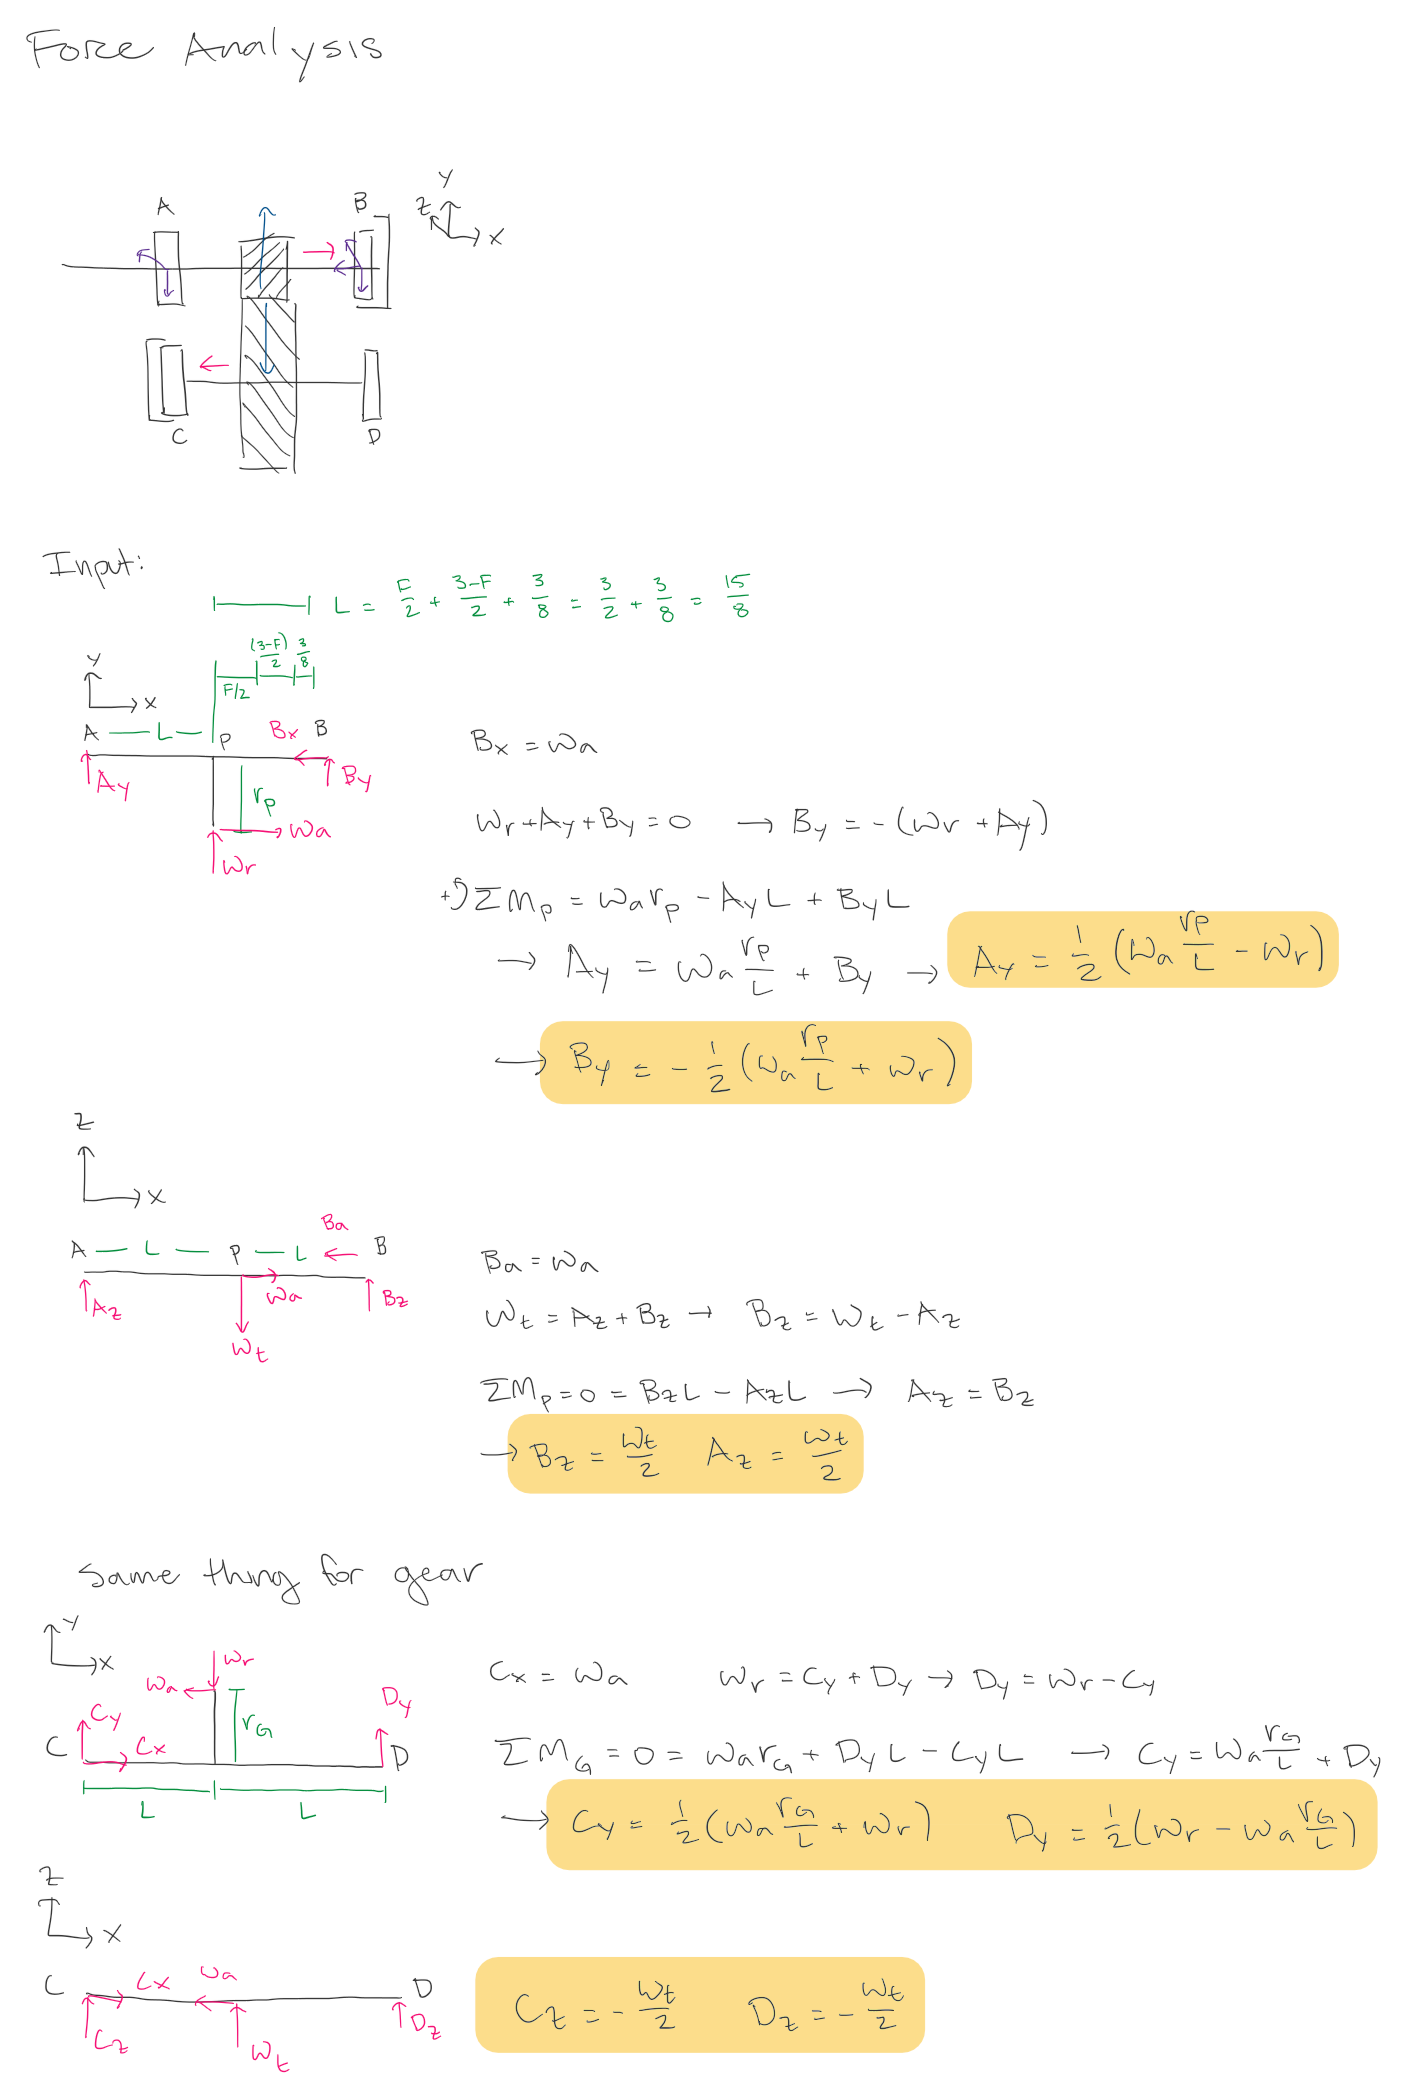

We need to find $W_t$, $W_r$, and $W_a$ for each gear. We can see that Bearings $A$ and $C$ are assumed to be fixed and carry the axial loads.

In [143]:
# Using equations 13-39 and 13-40 (Lecture 29 slide 6)

W_r = W_t * np.tan(phi_t)

W_a = W_t * np.tan(psi)

show(W_r, W_a)

W_r = 132.075
W_a = 181.437


In [144]:
# Calculations from the force analysis above

r_P = d_2/2
r_G = d_3/2

L = 15/8

A_y = (1/2)*(W_a * (r_P/L) - W_r)
B_y = -(1/2)*(W_a * (r_P/L) + W_r)

A_z = W_t/2
B_z = W_t/2

B_x = -W_a

show(A_y, B_y, A_z, B_z, B_x)

A_y = -35.310
B_y = -96.765
A_z = 157.129
B_z = 157.129
B_x = -181.437


In [145]:
C_y = (1/2)*(W_a * (r_G/L) + W_r)
D_y = (1/2)*(W_r - W_a * (r_G/L))

C_z = -W_t/2
D_z = -W_t/2

C_x = W_a*1

show(C_y, D_y, C_z, D_z, C_x)

C_y = 295.096
D_y = -163.021
C_z = -157.129
D_z = -157.129
C_x = 181.437


These are all in lbf. 

#### Shaft Forces

With all of these forces found, along with the torques from eariler, we can begin the force analysis for the shafts. 

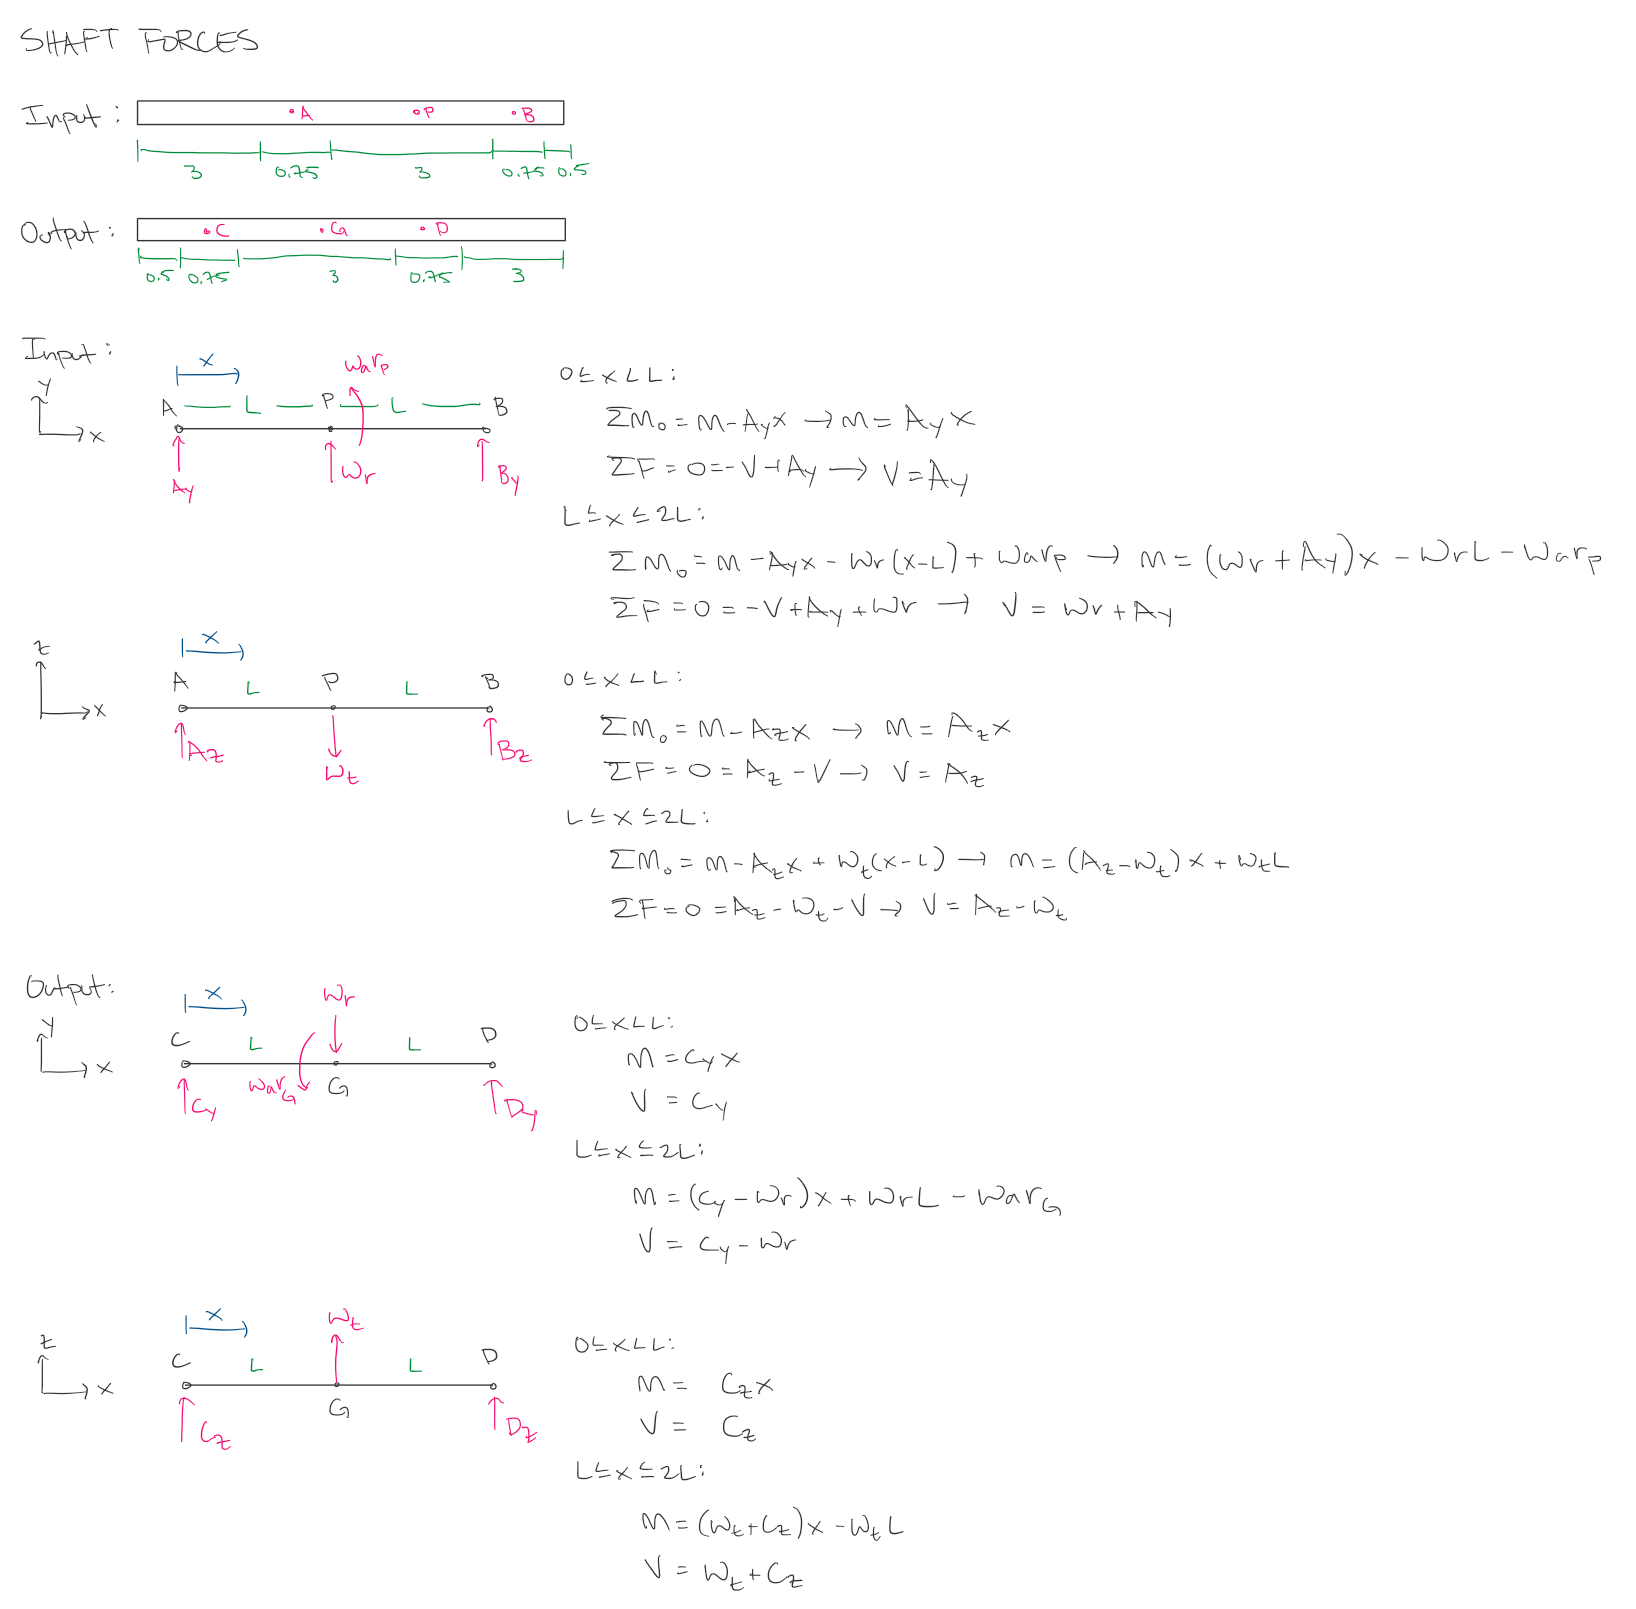

We can use these bending and shear force equations to find the radial bending moment and shear force at each point along the shaft using root-sum-squares.

In [146]:
# Defining shear and bending equations for each shaft
from enum import Enum
class Plane(Enum):
    XY = 0
    XZ = 1
    Combined = 2

def inputShaftBending(x: float, plane: Plane = Plane.Combined):
    L = 15/8
    if 0 <= x < L:
        MXY = A_y*x
        MXZ = A_z*x
    if L <= x <= 2*L:
        MXY = (W_r + A_y)*x - W_r*L - W_a*r_P
        MXZ = (A_z - W_t)*x + W_t*L

    match (plane):
        case Plane.XY:
            return MXY
        case Plane.XZ:
            return MXZ
        case Plane.Combined:
            return sqrt(MXY**2 + MXZ**2)
    

def inputShaftShear(x: float, plane: Plane = Plane.Combined):
    L = 15/8
    if 0 <= x < L:
        VXY = A_y
        VXZ = A_z
    if L <= x <= 2*L:
        VXY = (W_r + A_y)
        VXZ = (A_z - W_t)
    
    match (plane):
        case Plane.XY:
            return VXY
        case Plane.XZ:
            return VXZ
        case Plane.Combined:
            return sqrt(VXY**2 + VXZ**2)
    

def outputShaftBending(x: float, plane: Plane = Plane.Combined):
    L = 15/8
    if 0 <= x < L:
        MXY = C_y*x
        MXZ = C_z*x
    if L <= x <= 2*L:
        MXY = (C_y - W_r)*x + W_r*L - W_a*r_G
        MXZ = (W_t + C_z)*x - W_t*L
    
    match (plane):
        case Plane.XY:
            return MXY
        case Plane.XZ:
            return MXZ
        case Plane.Combined:
            return sqrt(MXY**2 + MXZ**2)

def outputShaftShear(x: float, plane: Plane = Plane.Combined):
    L = 15/8
    if 0 <= x < L:
        VXY = C_y
        VXZ = C_z
    if L <= x <= 2*L:
        VXY = (C_y - W_r)
        VXZ = (W_t + C_z)
    
    match (plane):
        case Plane.XY:
            return VXY
        case Plane.XZ:
            return VXZ
        case Plane.Combined:
            return sqrt(VXY**2 + VXZ**2)


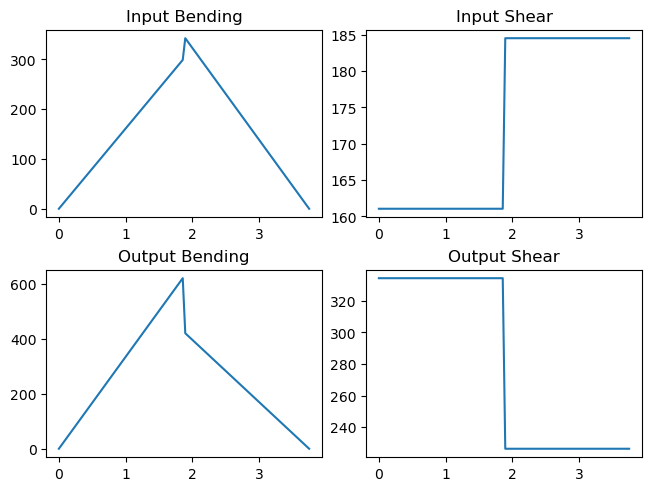

In [147]:
# COMBINED MOMENTS AND SHEAR

%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=2, nrows=2, layout='constrained')

x = np.linspace(0, 2*L, 100)

def quickPlot(xarray, function, ax, title='', **function_args):
    y = []
    for x in xarray:
        y.append(function(x, **function_args))
    
    ax.plot(xarray, y)
    ax.set_title(title)

quickPlot(x, inputShaftBending, axs[0,0], "Input Bending")
quickPlot(x, inputShaftShear, axs[0,1], "Input Shear")
quickPlot(x, outputShaftBending, axs[1,0], "Output Bending")
quickPlot(x, outputShaftShear, axs[1,1], "Output Shear")

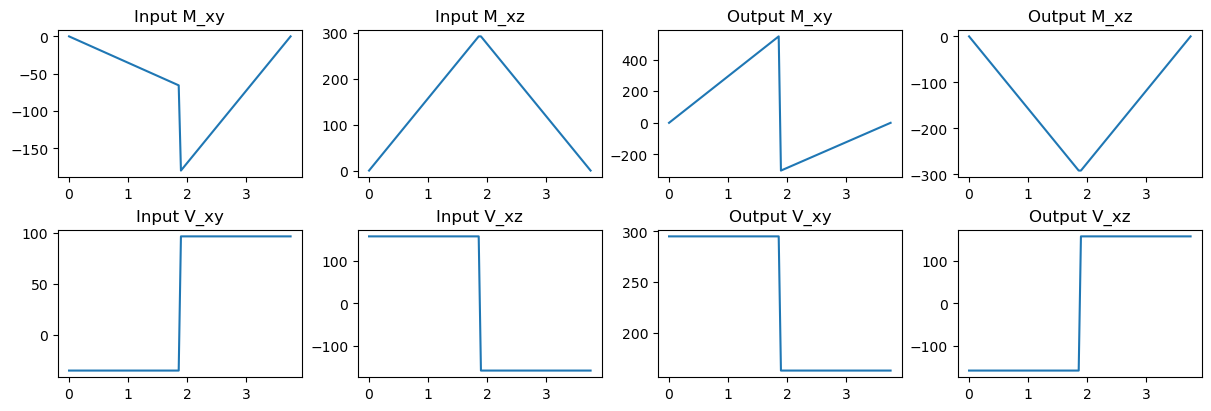

In [148]:
# INDIVIDUAL MOMENTS AND SHEAR

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(12,4), layout='constrained')

# Input shaft in first four plots, with bending on top and shear on bottom
quickPlot(x, inputShaftBending, axs[0,0], title='Input M_xy', plane = Plane.XY)
quickPlot(x, inputShaftShear, axs[1,0], title='Input V_xy', plane = Plane.XY)

quickPlot(x, inputShaftBending, axs[0,1], title='Input M_xz', plane = Plane.XZ)
quickPlot(x, inputShaftShear, axs[1,1], title='Input V_xz', plane = Plane.XZ)

# Output shaft
quickPlot(x, outputShaftBending, axs[0,2], title='Output M_xy', plane = Plane.XY)
quickPlot(x, outputShaftShear, axs[1,2], title='Output V_xy', plane = Plane.XY)

quickPlot(x, outputShaftBending, axs[0,3], title='Output M_xz', plane = Plane.XZ)
quickPlot(x, outputShaftShear, axs[1,3], title='Output V_xz', plane = Plane.XZ)

## Shaft Analysis

This is going to be the section with a lot of code.

This section analyzes the stresses at several critical locations along the shaft. These stresses will define minimum viable diameters at each point, which can then be used to create a shaft design with diameters included. The key contributers to stresses inside the shaft are internal bending moments and the applied torque. 

Note that we are assuming axial loads have negligible effect on the stresses within the shaft. This is for several reasons. First, the magnitude of the axial load is small compared to the magnitude of the internal bending load, which means it has far less impact on the internal normal stresses. Second, the axial load within the shaft is transmitted by the helical gears, and thus is a constant load, not alternating. This means the axial load contributes very little to fatigue within the shaft (Pg 401 of the textbook). Lastly, the axial load within the shaft is compressive between the gear and the bearing supporting the load, and light compressive loads can often be beneficial to fatigue life, so ignoring the effect of axial loads could even be a more conservative approximation (Pg 330 of the textbook). With all of these reasons, we can safely assume the axial load has little effect on the stresses of the beam, and thus it can safely be ignored in the preceding calculations. 

Below is shown the dimensions of each point of analysis on each shaft:

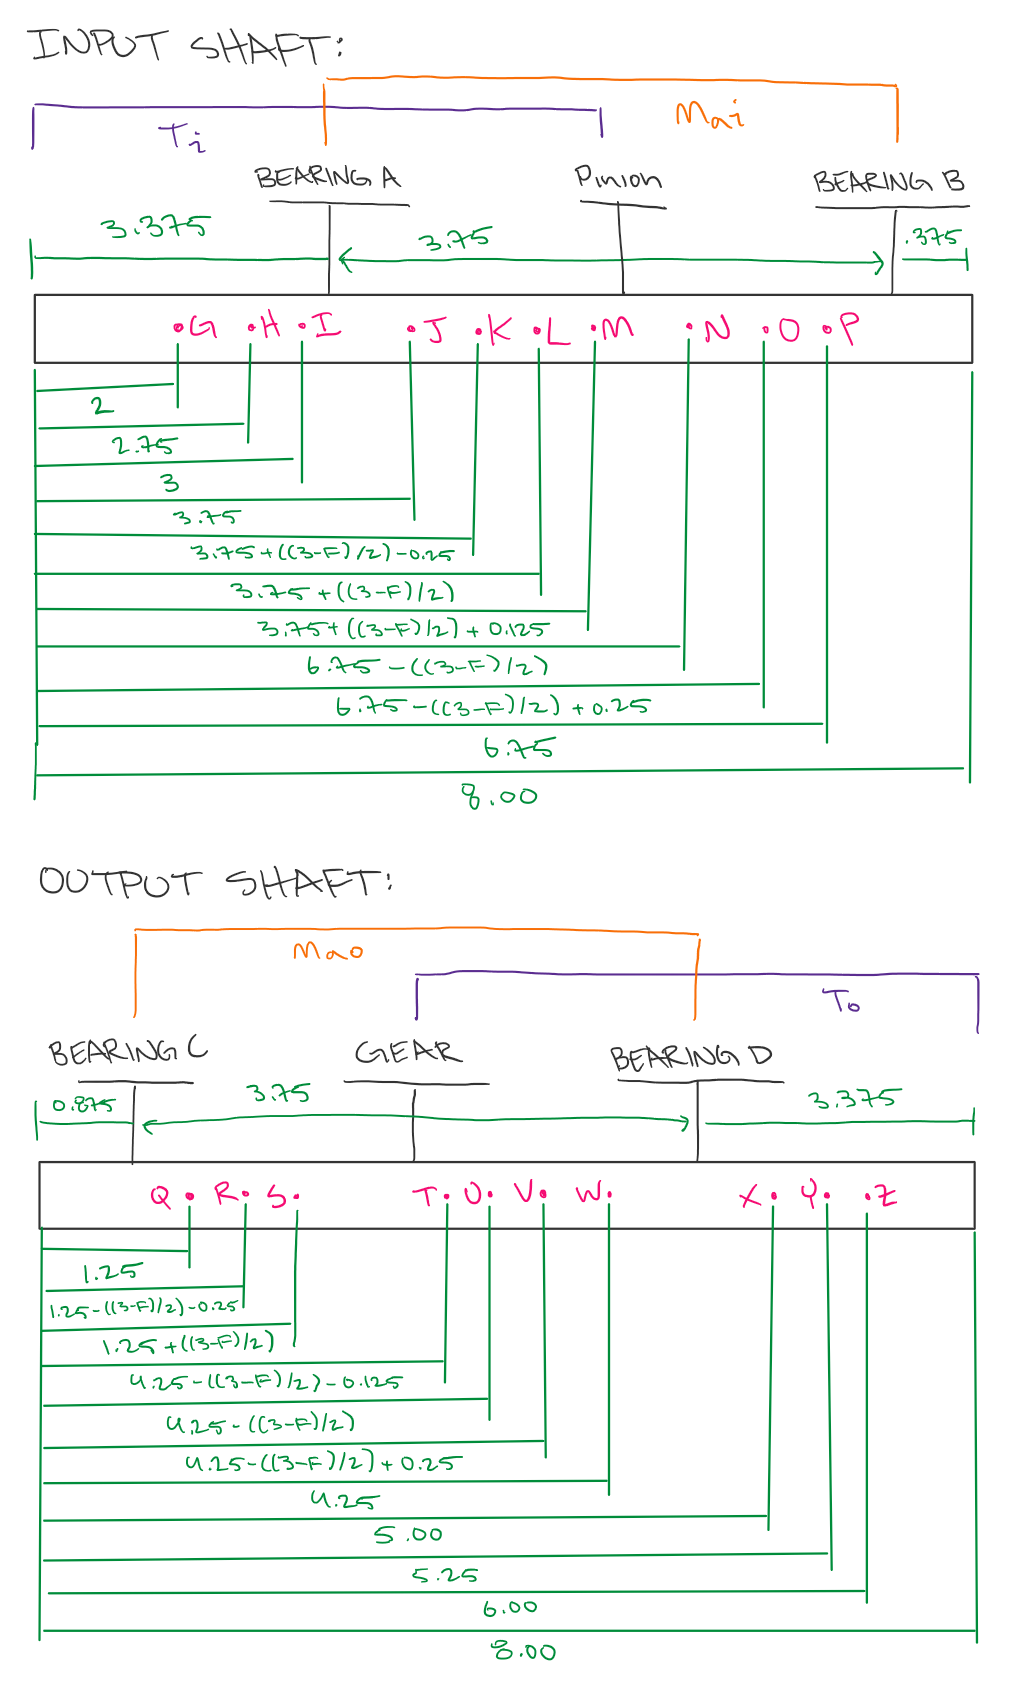

The location of interest at each of these points is defined in the input and output shaft sketch files. For this analysis, these will be the stress concentrations at each type of location:

- Bearing shoulders : sharp fillet radius
- Other shoulders : well-rounded fillet radius
- Retaining rings : retaining-ring groove
- Keyways : keyway notch

In [149]:
# Length of shafts
L_shaft = 8.0

# Defining Ma functions for input and output shafts that consider the entire length of the shaft (only returns values in orange regions)

def input_Ma(x: float):
    if 3.375 <= x <= 3.375 + 3.75:
        return inputShaftBending(x - 3.375)
    else:
        return 0
    
def output_Ma(x: float):
    if 0.875 <= x <= 0.875 + 3.75:
        return outputShaftBending(x - 0.875)
    else:
        return 0

In [150]:
# Defining Tm functions that return corresponding torque at x location (in purple region)

def input_Tm(x: float):
    if 0 <= x <= 3.375 + (3.75/2):
        return T_2
    else:
        return 0
    
def output_Tm(x: float):
    if 0.875 + (3.75/2) <= x <= L_shaft:
        return T_3
    else:
        return 0

In [151]:
from src import ShaftDesign as sd

# NOTE: material strengths are defined by the group. For our group it's AISI 1010 CD with S_ut = 53 ksi and S_y = 44 ksi

# Defining input shaft
input_shaft = sd.Shaft(
    units = sd.units.Imperial,
    material = sd.materials.Strengths(S_ut=53, S_y=44),
    surface_finish = sd.SurfaceFinish.Machined,

    length = L_shaft,

    n = 1.5,

    Ma = input_Ma,
    Mm = 0,
    Ta = 0,
    Tm = input_Tm,

    # Defining the axial location of each point and its associated stress concentration
    points = {
        'G' : sd.PointProperties(
            location = 2.0,
            stress_concentration = sd.NotchType.Keyway,
        ),
        'H' : sd.PointProperties(2.75, sd.NotchType.Well_Rounded),
        'I' : sd.PointProperties(3.0, sd.NotchType.Retaining_Ring),
        'J' : sd.PointProperties(3.75, sd.NotchType.Sharp),
        'K' : sd.PointProperties(3.75 + ((3-F)/2) - 0.25, sd.NotchType.Well_Rounded),
        'L' : sd.PointProperties(3.75 + ((3-F)/2), sd.NotchType.Retaining_Ring),
        'M' : sd.PointProperties(3.75 + ((3-F)/2) + 0.125, sd.NotchType.Keyway),
        'N' : sd.PointProperties(6.75 - ((3-F)/2), sd.NotchType.Well_Rounded),
        'O' : sd.PointProperties(6.75 - ((3-F)/2) + 0.25, sd.NotchType.Well_Rounded),
        'P' : sd.PointProperties(6.75, sd.NotchType.Sharp)
    }
)

In [152]:
# Defining output shaft

output_shaft = sd.Shaft(
    units = sd.units.Imperial,
    material = sd.materials.Strengths(S_ut=53, S_y=44),
    surface_finish = sd.SurfaceFinish.Machined,

    n = 1.5,

    length = L_shaft,

    Ma = output_Ma,
    Mm = 0,
    Ta = 0,
    Tm = output_Tm,

    points = {
        'Q' : sd.PointProperties(1.25, sd.NotchType.Sharp),
        'R' : sd.PointProperties(1.25 + ((3-F)/2) - 0.25, sd.NotchType.Well_Rounded),
        'S' : sd.PointProperties(1.25 + ((3-F)/2), sd.NotchType.Well_Rounded),
        'T' : sd.PointProperties(4.25 - ((3-F)/2) - 0.125, sd.NotchType.Keyway),
        'U' : sd.PointProperties(4.25 - ((3-F)/2), sd.NotchType.Retaining_Ring),
        'V' : sd.PointProperties(4.25 - ((3-F)/2) + 0.25, sd.NotchType.Well_Rounded),
        'W' : sd.PointProperties(4.25, sd.NotchType.Sharp),
        'X' : sd.PointProperties(5.00, sd.NotchType.Retaining_Ring),
        'Y' : sd.PointProperties(5.25, sd.NotchType.Well_Rounded),
        'Z' : sd.PointProperties(6.00, sd.NotchType.Keyway)
    }
)

In [153]:
# Defining analyzers for each shaft and solving for diameters
input_analyzer = sd.ShaftAnalyzer(input_shaft, sd.DataPrinter('.3f', 4, output_file='input_shaft.txt'))
output_analyzer = sd.ShaftAnalyzer(output_shaft, sd.DataPrinter('.3f', 4, output_file='output_shaft.txt'))

In [154]:
# Solving for diameters at each point on the input shaft
input_analyzer.solveUsing([sd.Criterion.Goodman, sd.Criterion.YieldingConservative])
display(input_analyzer.table)

,G,H,I,J,K,L,M,N,O,P
Criterion.Goodman,0.465976,0.406254,0.467270,0.543231,0.603961,0.787718,0.698961,0.607905,0.556429,0.441301
Criterion.YieldingConservative,0.497106,0.432606,0.497175,0.513251,0.534975,0.669116,0.617292,0.471209,0.432670,0.343808


In [155]:
# Solving for diameters on the output shaft
output_analyzer.solveUsing([sd.Criterion.Goodman, sd.Criterion.YieldingConservative])
display(output_analyzer.table)

,Q,R,S,T,U,V,W,X,Y,Z
Criterion.Goodman,0.546681,0.685885,0.749280,1.060952,1.097650,0.905978,0.914530,0.912799,0.800096,0.936345
Criterion.YieldingConservative,0.422619,0.529377,0.576494,1.050825,1.052078,0.897273,0.939127,0.971217,0.851881,0.998485


In [156]:
# Taking the maximum diameter for each point from each criterion as the minimum allowable diameter

input_diameters = input_analyzer.table.max()
output_diameters = output_analyzer.table.max()

display(input_diameters)
display(output_diameters)

G    0.497106
H    0.432606
I    0.497175
J    0.543231
K    0.603961
L    0.787718
M    0.698961
N    0.607905
O    0.556429
P    0.441301
dtype: float64

Q    0.546681
R    0.685885
S    0.749280
T    1.060952
U    1.097650
V    0.905978
W    0.939127
X    0.971217
Y    0.851881
Z    0.998485
dtype: float64

We can now find diametral layouts for using these minimum required diameters. Some of these diameters drive the design of the shaft, these critical diameters have arrows on each end, where the other diameters which are overtaken by the critical ones have bars. Diameters not in green are not limited by fatigue or yield requirements, but instead are geometry requirements for assembling the shaft, since shoulders are required to be at least 1.1 times larger than the smaller diameter.

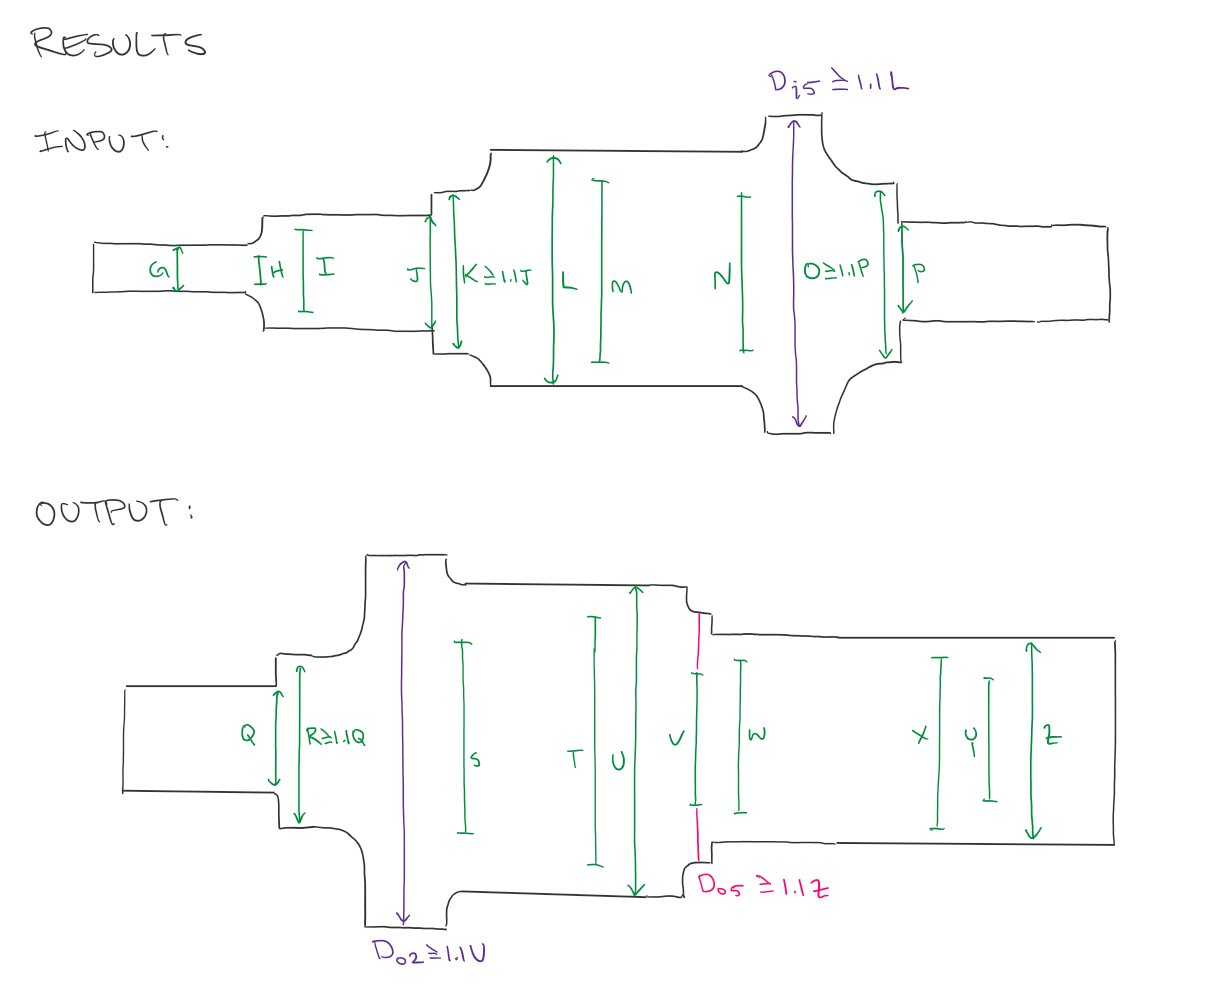


In [157]:
# Checking that shoulder requirements are met
print(f"K >= 1.1J? {input_diameters['K'] >= 1.1*input_diameters['J']}")

print(f"O >= 1.1P? {input_diameters['O'] >= 1.1*input_diameters['P']}")
print(f"R >= 1.1Q? {output_diameters['R'] >= 1.1*output_diameters['Q']}")

K >= 1.1J? True
O >= 1.1P? True
R >= 1.1Q? True


In [158]:
# Calculating D_i5, D_02, and D_o5

input_diameters['D_i5'] = 1.1 * input_diameters['L']

output_diameters['D_o2'] = 1.1 * output_diameters['U']
output_diameters['D_o5'] = 1.1 * output_diameters['Z']

display(input_diameters)
display(output_diameters)

G       0.497106
H       0.432606
I       0.497175
J       0.543231
K       0.603961
L       0.787718
M       0.698961
N       0.607905
O       0.556429
P       0.441301
D_i5    0.866490
dtype: float64

Q       0.546681
R       0.685885
S       0.749280
T       1.060952
U       1.097650
V       0.905978
W       0.939127
X       0.971217
Y       0.851881
Z       0.998485
D_o2    1.207416
D_o5    1.098334
dtype: float64

It turns out that $D_{o5}$ is larger than $D_U$, so the actual output shaft layout will look something like this:

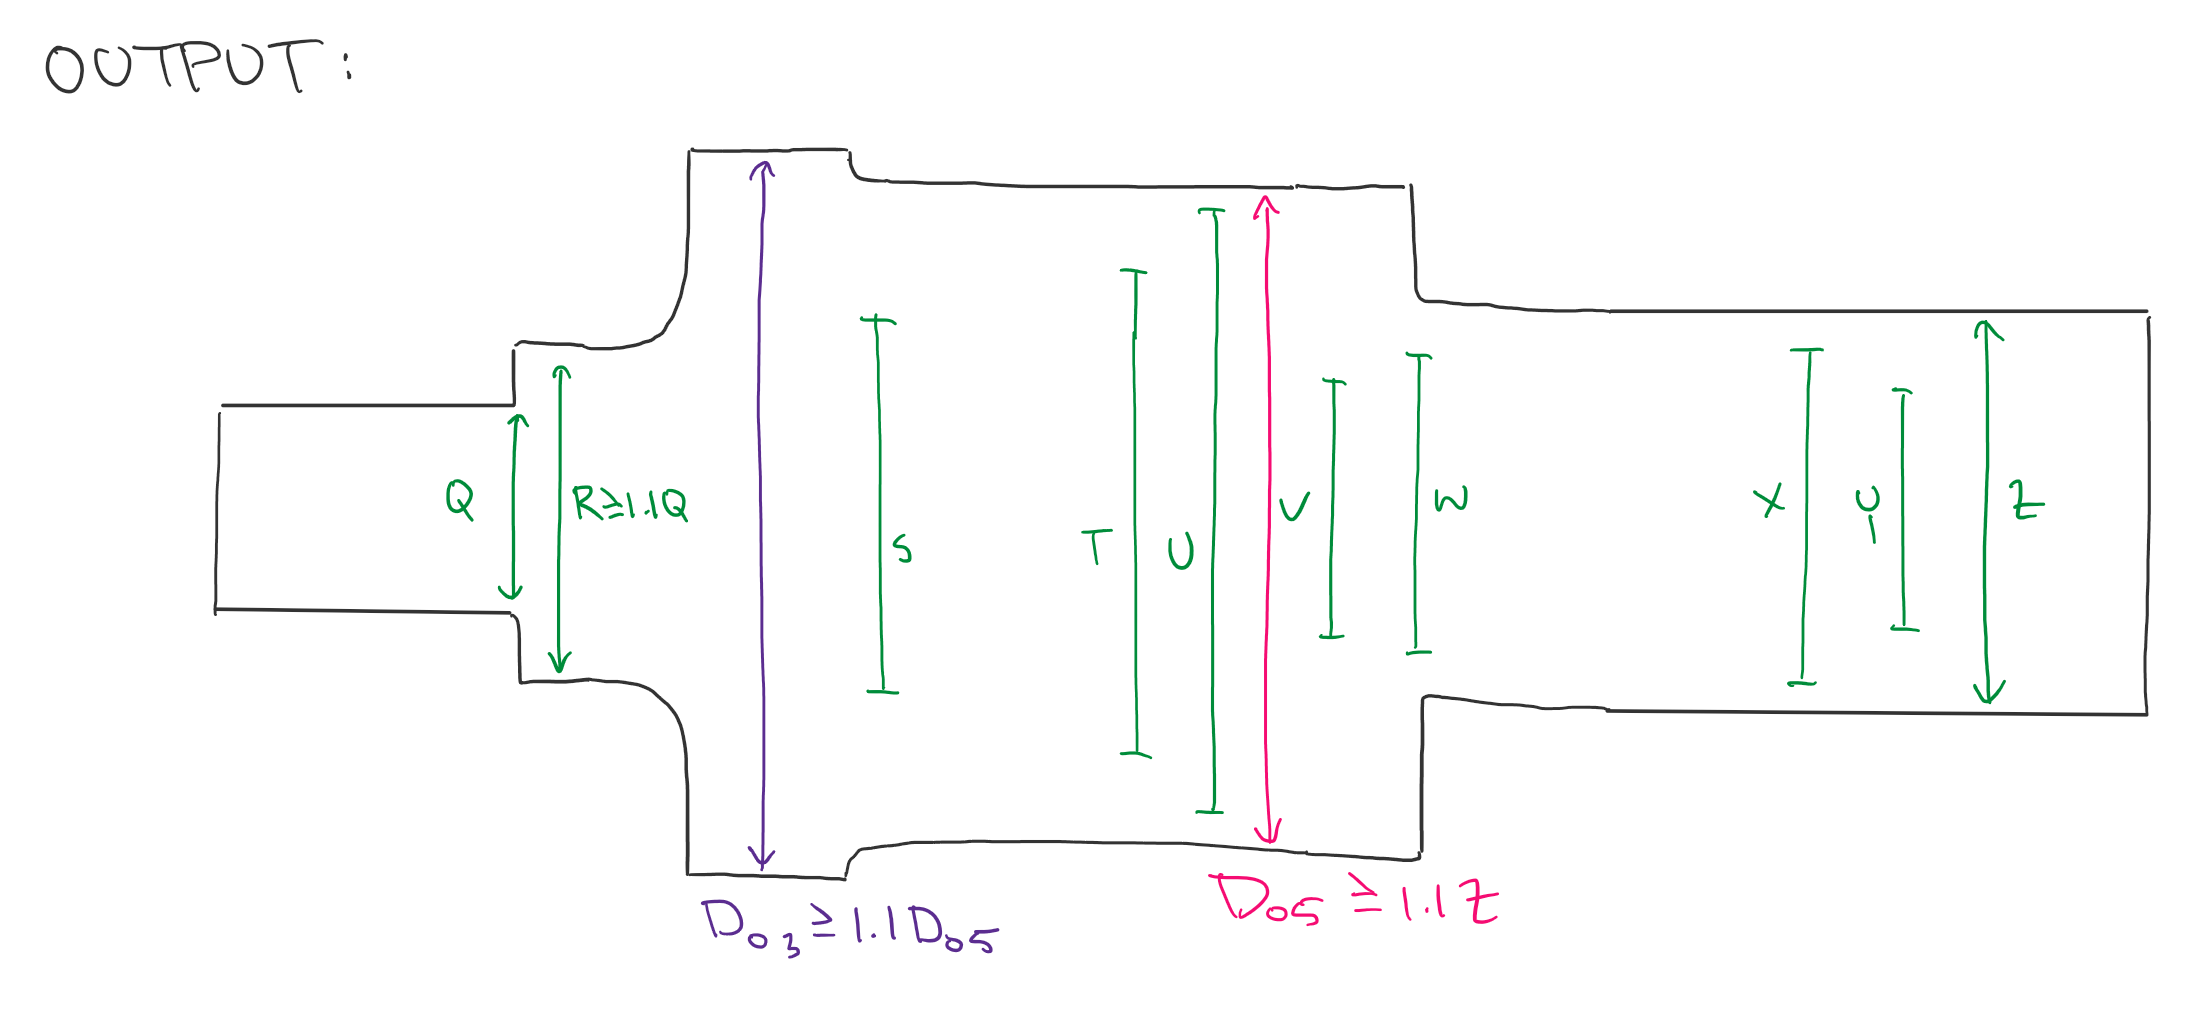

In [159]:
output_diameters['D_o2'] = 1.1 * output_diameters['D_o5']

print(f"D_02 = {output_diameters['D_o2']}")

D_02 = 1.2081670803285933


With the shaft diameters found we need to find the new safety factor at each point. Some points no longer have stress concentrations, and that is reflected in the code.

In [160]:
# Redefining diameters to meet shaft layouts above 

input_diameters['H'] = input_diameters['J']
input_diameters['I'] = input_diameters['J']
input_diameters['M'] = input_diameters['L']
input_diameters['N'] = input_diameters['L']

output_diameters['S'] = output_diameters['D_o5']
output_diameters['T'] = output_diameters['D_o5']
output_diameters['U'] = output_diameters['D_o5']
output_diameters['V'] = output_diameters['Z']
output_diameters['W'] = output_diameters['Z']
output_diameters['X'] = output_diameters['Z']
output_diameters['Y'] = output_diameters['Z']

display(input_diameters)
display(output_diameters)

G       0.497106
H       0.543231
I       0.543231
J       0.543231
K       0.603961
L       0.787718
M       0.787718
N       0.787718
O       0.556429
P       0.441301
D_i5    0.866490
dtype: float64

Q       0.546681
R       0.685885
S       1.098334
T       1.098334
U       1.098334
V       0.998485
W       0.998485
X       0.998485
Y       0.998485
Z       0.998485
D_o2    1.208167
D_o5    1.098334
dtype: float64

In [161]:
# Calculating the safety factor at each letter point using the found diameters

input_shaft = sd.Shaft(
    units = sd.units.Imperial,
    material = sd.materials.Strengths(S_ut=53, S_y=44),
    surface_finish = sd.SurfaceFinish.Machined,

    length = L_shaft,

    d = input_diameters.drop(['D_i5']).to_dict(),

    Ma = input_Ma,
    Mm = 0,
    Ta = 0,
    Tm = input_Tm,

    # Defining the axial location of each point and its associated stress concentration
    points = {
        'G' : sd.PointProperties(
            location = 2.0,
            stress_concentration = sd.NotchType.Keyway,
        ),
        'H' : sd.PointProperties(2.75, sd.NotchType.Well_Rounded),
        'I' : sd.PointProperties(3.0, sd.NotchType.Retaining_Ring),
        'J' : sd.PointProperties(3.75, sd.NotchType.Sharp),
        'K' : sd.PointProperties(3.75 + ((3-F)/2) - 0.25, sd.NotchType.Well_Rounded),
        'L' : sd.PointProperties(3.75 + ((3-F)/2), sd.NotchType.Retaining_Ring),
        'M' : sd.PointProperties(3.75 + ((3-F)/2) + 0.125, sd.NotchType.Keyway),
        'N' : sd.PointProperties(6.75 - ((3-F)/2), sd.NotchType.Well_Rounded),
        'O' : sd.PointProperties(6.75 - ((3-F)/2) + 0.25, sd.NotchType.Well_Rounded),
        'P' : sd.PointProperties(6.75, sd.NotchType.Sharp)
    }
)

output_shaft = sd.Shaft(
    units = sd.units.Imperial,
    material = sd.materials.Strengths(S_ut=53, S_y=44),
    surface_finish = sd.SurfaceFinish.Machined,

    d = output_diameters.drop(['D_o2', 'D_o5']).to_dict(),

    length = L_shaft,

    Ma = output_Ma,
    Mm = 0,
    Ta = 0,
    Tm = output_Tm,

    points = {
        'Q' : sd.PointProperties(1.25, sd.NotchType.Sharp),
        'R' : sd.PointProperties(1.25 + ((3-F)/2) - 0.25, sd.NotchType.Well_Rounded),
        'S' : sd.PointProperties(1.25 + ((3-F)/2), sd.NotchType.Well_Rounded),
        'T' : sd.PointProperties(4.25 - ((3-F)/2) - 0.125, sd.NotchType.Keyway),
        'U' : sd.PointProperties(4.25 - ((3-F)/2), sd.NotchType.Retaining_Ring),
        'V' : sd.PointProperties(4.25 - ((3-F)/2) + 0.25, sd.NotchType.Nothing),
        'W' : sd.PointProperties(4.25, sd.NotchType.Sharp),
        'X' : sd.PointProperties(5.00, sd.NotchType.Retaining_Ring),
        'Y' : sd.PointProperties(5.25, sd.NotchType.Nothing),
        'Z' : sd.PointProperties(6.00, sd.NotchType.Keyway)
    }
)

input_safety_factor_calculator = sd.ShaftAnalyzer(input_shaft, printer=sd.DataPrinter('.3f', 3, output_file='input_safety_factors.txt'))
output_safety_factor_calculator = sd.ShaftAnalyzer(output_shaft, printer=sd.DataPrinter('.3f', 3, output_file='output_safety_factors.txt'))

In [162]:
input_safety_factor_calculator.solveUsing([sd.Criterion.Goodman, sd.Criterion.YieldingConservative])
display(input_safety_factor_calculator.table)

,G,H,I,J,K,L,M,N,O,P
Criterion.Goodman,1.807342,3.549274,2.356892,1.501020,1.500469,1.505412,2.105066,3.134783,1.501111,1.503408
Criterion.YieldingConservative,1.500435,2.946567,1.956665,1.768841,2.148680,2.447367,3.053866,6.830853,3.151573,3.079068


In [163]:
output_safety_factor_calculator.solveUsing([sd.Criterion.Goodman, sd.Criterion.YieldingConservative])
display(output_safety_factor_calculator.table)

,Q,R,S,T,U,V,W,X,Y,Z
Criterion.Goodman,1.502977,1.500946,4.455668,1.665990,1.504023,2.843111,1.942075,1.963318,4.020047,1.813270
Criterion.YieldingConservative,3.149529,3.222552,10.060677,1.710451,1.706675,2.892621,1.797767,1.629924,3.337398,1.505356


## Bearing Selection

Using the forces calculated in previous sections we can calculate the required $C_{10}$ value for each bearing. Bearings B and C will need to take axial loads. We will assume for each shaft that a ball bearing will be selected to take the axial load and a strait roller bearing will compliment the ball bearing. 

Desing parameters:
- 1000 hours of life
- Application factor of 1.4
- Individual bearing reliability of 97.5%

Other things to note (or that I'm writing down here for reference):
- $a = 3$ for ball bearings and $10/3$ for roller bearings
- For ball and straight roller bearings we use manufacturer 2 in Table 11-6, so $L_{10} = 1\cdot10^6$, $x_0 = 0.02$, $\theta = 4.459$, and $b = 1.483$.

In [164]:
L_hours = 1000
a_f = 1.4
R_D = 0.975

a_ball = 3
a_roller = 10/3

# Weibull parameter stuff
L_10 = 1e6
x_0 = 0.02
theta = 4.459
b = 1.483

In [165]:
# Calculating L_D for each bearing

L_D = {
    'A' : L_hours * input_speed * 60,     # Equation 11-3
    'B' : L_hours * input_speed * 60,
    'C' : L_hours * output_speed_actual * 60,
    'D' : L_hours * output_speed_actual * 60
}

print(L_D)

{'A': 180000000, 'B': 180000000, 'C': 24146341.463414636, 'D': 24146341.463414636}


In [166]:
# Calculating x_D for each bearing
x_D = {}
for bearing, l_d in L_D.items():
    x_D[bearing] = l_d/L_10

print(x_D)

{'A': 180.0, 'B': 180.0, 'C': 24.146341463414636, 'D': 24.146341463414636}


In [167]:
# Calculating total radial load at each bearing
radial_loads = {
    'A' : sqrt(A_y**2 + A_z**2),
    'B' : sqrt(B_y**2 + B_z**2),
    'C' : sqrt(C_y**2 + C_z**2),
    'D' : sqrt(D_y**2 + D_z**2),
}

print(radial_loads)

{'A': 161.04733848569532, 'B': 184.5342554381562, 'C': 334.3221102101947, 'D': 226.41856231981905}


In [168]:
# Calculating required C_10 for the bearings not carrying axial loads

C_10 = {}
for bearing in ['A', 'D']:
    # Equation 11-9
    C_10[bearing] = a_f * radial_loads[bearing] * ( x_D[bearing] / (x_0 + (theta - x_0)*(np.log(1/R_D))**(1/b)) )**(1/a_roller)

print(C_10)

{'A': 1417.8570442980551, 'D': 1091.1000396850466}


In [169]:
# Getting conversions for C_10 to kN

for bearing, c10 in C_10.items():
    print(f'Bearing {bearing} = {c10:.3f} lbf = C_10 = {c10/224.808943:.3f} kN')  # lbf to kN conversion factor

Bearing A = 1417.857 lbf = C_10 = 6.307 kN
Bearing D = 1091.100 lbf = C_10 = 4.853 kN


Using these $C_{10}$ values, along with their associated diameters on the shaft as a minimum bore size, we can select bearings A and D. 

In [170]:
print(f"Bearing A Bore Diameter = {input_diameters['J']:.3f} in = {input_diameters['J'] * 25.4:.3f} mm")
print(f"Bearing D Bore Diameter = {output_diameters['Z']:.3f} in = {output_diameters['Z'] * 25.4:.3f} mm")

Bearing A Bore Diameter = 0.543 in = 13.798 mm
Bearing D Bore Diameter = 0.998 in = 25.362 mm


From the skf website [this](https://www.skf.com/us/products/rolling-bearings/ball-bearings/deep-groove-ball-bearings/productid-W%206202) bearing fits the criteria for bearing A, These are the general specifications:

- Specification: W 6202
- Bore diameter : 0.591 in = 15 mm
- Outer diameter : 1.378 in = 35 mm
- Width : 0.433 in = 11 mm
- Dynamic load rating ($C_{10}$) : 1432 lbf = 6.37 kN

For bearing D I selected [this](https://www.skf.com/us/products/rolling-bearings/roller-bearings/cylindrical-roller-bearings/single-row-cylindrical-roller-bearings/productid-NU%201006) bearing:

- Specification: NU 1006
- Bore diameter : 1.181 in = 30 mm
- Outer diameter : 2.165 in = 55 mm
- Width : 0.512 in = 13 mm
- Dynamic load rating ($C_{10}$) : 4024 lbf = 17.9 kN



The process for identifying a C_10 value for the axially loaded bearings is a little more difficult. We need a $C_0$ value to calculate the required $C_{10}$ value, and these are specific to each bearing. Because we don't know the bearing we need, we can't immediately specify the $C_0$ value . Thus some iteration is required. The algorithm for this process is defined in the lecture:

1. Pick an initial guess for $F_e$ by simply taking the sum $F_e = F_a + F_r$
2. Find $C_{10}$ using the guessed $F_e$
3. Identify a suitable bearing and get its $C_0$ value.
4. Use $F_a / C_0$ to interpolate a $Y_2$ value
5. Use $Y_2$ to get a new guess for $F_e$
5. Repeat steps, if two subsequently chosen suitable bearings are the same, then stop.

We will first apply this alforithm to find bearing B and then C.

In [171]:
print(f"Bearing B Bore Diameter = {input_diameters['P']:.3f} in = {input_diameters['P'] * 25.4:.3f} mm")
print(f"Bearing C Bore Diameter = {output_diameters['Q']:.3f} in = {output_diameters['Q'] * 25.4:.3f} mm")

Bearing B Bore Diameter = 0.441 in = 11.209 mm
Bearing C Bore Diameter = 0.547 in = 13.886 mm


In [172]:
# Bearing B first

F_e = W_a + radial_loads['B']
show(F_e)

F_e = 365.971


In [173]:
def show_c10_with_kN(c10):
    print(f'C_10 = {c10:.3f} lbf = {c10/224.808943:.3f} kN')

# Equation 11-9
C_10 = a_f * F_e * ( x_D['B'] / (x_0 + (theta - x_0)*(np.log(1/R_D))**(1/b)) )**(1/a_ball)
show_c10_with_kN(C_10)

C_10 = 3952.331 lbf = 17.581 kN


[SKF 6304 ETN9](https://www.skf.com/us/products/rolling-bearings/ball-bearings/deep-groove-ball-bearings/productid-6304%20ETN9) fits these criteria: $C_0$ = 2023 lbf = 9 kN

In [174]:
Fa_C0 = W_a/2023
print(f'F_a/C_0 = {Fa_C0:.3f}')

F_a/C_0 = 0.090


In [175]:
# Interpolating from Table 11-1:
X_2 = 0.56

# Since F_a/C_0 is smaller than the smallest entry on the table we assume Y_2 = 2.30
Y_2 = 2.30
show(Y_2)

Y_2 = 2.300


In [176]:
# V = 1 because the inner ring is rotating
V = 1

F_e = X_2*V*radial_loads['B'] + Y_2*W_a
show(F_e)

F_e = 520.643


In [177]:
C_10 = a_f * F_e * ( x_D['B'] / (x_0 + (theta - x_0)*(np.log(1/R_D))**(1/b)) )**(1/a_ball)
show_c10_with_kN(C_10)

C_10 = 5622.729 lbf = 25.011 kN


We can see that the required diameter for this is way too large, so we need to shift to a set of tapered rollers for the input shaft. 

### Bearing C Selection

This was done in matlab, these are screenshots of the code:

![Bearing C 1](matlab_code\\Bearing_C_Part_1_with_Equations.JPG)

![Bearing C 2](matlab_code\\Bearing_C_Part_2_with_Equations.JPG)

![Bearing C 3](matlab_code\\Bearing_C_Part_3_with_Equations.JPG)


### Tapered Roller Bearing Analysis

Tapered rollers change the weibull parameters since we are using Timken (manufacturer 1). We will use indirect mounting on the bearings to keep the shaft in compression, which means that shaft analysis doesn't need to be done again.

For tapered roller bearings the equation for $F_e$ is:

$$
F_e = 0.4F_r + KF_a \tag{pg 600 (a)}
$$

Where $F_a$ is the net axial load applied to a bearing. This external load is also dependent on the induced load from bearing $B$:

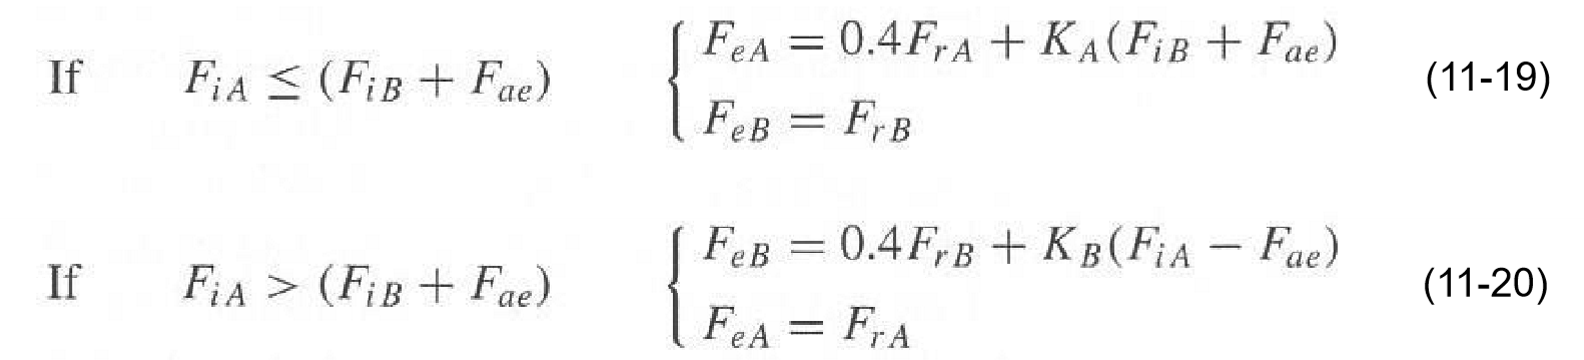

Induced loads are calculated using:

$$
F_{i} = \dfrac{0.47 F_{r}}{K} \tag{11-18}
$$

So the basic process here will be:
1. Use the initial $K = 1.5$ guess to get initial esimates for the induced loads
2. Find the bearing carrying the axial load by comparing $F_{iA}$ and $F_{iB} + F_{ae}$. Use the equations above to calculate the effective load applied to each bearing. 
3. Use the effective load to calculate the neccesary $C_{10}$ value for each bearing. Tentatively select bearings that meet these requirements. 
4. Repeat process using the $K$ values for the bearings selected beore ($K_A$ and $K_B$). If the bearings selected match the tentative bearings, then stop. If not, repeat. 

In this analysis, bearing B is taking the axial load, so very confusingly all references to bearing A in these equations are actually bearing B, and B is bearing A.

In [178]:
L_10 = 90e6
x_0 = 0
theta = 4.48
b = 1.5

In [179]:
x_D = {}
for bearing, l_d in L_D.items():
    x_D[bearing] = l_d/L_10

print(x_D)

{'A': 2.0, 'B': 2.0, 'C': 0.2682926829268293, 'D': 0.2682926829268293}


In [180]:
print(f"Bearing B Bore Diameter = {input_diameters['P']:.3f} in = {input_diameters['P'] * 25.4:.3f} mm")
print(f"Bearing A Bore Diameter = {input_diameters['J']:.3f} in = {input_diameters['J'] * 25.4:.3f} mm")

Bearing B Bore Diameter = 0.441 in = 11.209 mm
Bearing A Bore Diameter = 0.543 in = 13.798 mm


In [181]:
K_A = K_B = 1.5

F_iB = (0.47 * radial_loads['B'])/K_B
F_iA = (0.47 * radial_loads['A'])/K_A

print(f'F_iB <= (F_iA + W_a) ? {F_iB <= (F_iA + W_a)}')

F_iB <= (F_iA + W_a) ? True


In [182]:
F_eB = 0.4*radial_loads['B'] + K_B*(F_iA + W_a)
F_eA = radial_loads['A']

show(F_eB, F_eA)

F_eB = 421.661
F_eA = 161.047


In [183]:
C_10B = a_f * F_eB * ( x_D['B'] / (x_0 + (theta - x_0)*(np.log(1/R_D))**(1/b)) )**(1/a_roller)
C_10A = a_f * F_eA * ( x_D['A'] / (x_0 + (theta - x_0)*(np.log(1/R_D))**(1/b)) )**(1/a_roller)

show(C_10B, C_10A)

C_10B = 966.789
C_10A = 369.251


From the Timken catalog in the project resources, part number 0050(inner)-00150(outer) fits the requirements for bearing B. Part number A4059-A4138 meets the requirements for bearing A.

B: 0050-00150
- $C_{90}$ = 1220 lbf
- $K$ = 2.12

A: A4059-A4138
- $C_{90}$ = 767 lbg
- $K$ = 1.29

In [184]:
K_B = 2.12
K_A = 1.29

F_iB = (0.47 * radial_loads['B'])/K_B
F_iA = (0.47 * radial_loads['A'])/K_A

print(f'F_iB <= (F_iA + W_a) ? {F_iB <= (F_iA + W_a)}')

F_iB <= (F_iA + W_a) ? True


In [185]:
F_eB = 0.4*radial_loads['B'] + K_B*(F_iA + W_a)
F_eA = radial_loads['A']

show(F_eB, F_eA)

F_eB = 582.853
F_eA = 161.047


In [186]:
C_10B = a_f * F_eB * ( x_D['B'] / (x_0 + (theta - x_0)*(np.log(1/R_D))**(1/b)) )**(1/a_roller)
C_10A = a_f * F_eA * ( x_D['A'] / (x_0 + (theta - x_0)*(np.log(1/R_D))**(1/b)) )**(1/a_roller)

show(C_10B, C_10A)

C_10B = 1336.372
C_10A = 369.251


B: 03062-03162
- $C_{90}$ = 1400 lbf
- $K$ = 1.88

Selection for bearing A is the same

In [187]:
K_B = 1.88

F_iB = (0.47 * radial_loads['B'])/K_B
F_iA = (0.47 * radial_loads['A'])/K_A

print(f'F_iB <= (F_iA + W_a) ? {F_iB <= (F_iA + W_a)}')

F_iB <= (F_iA + W_a) ? True


In [188]:
F_eB = 0.4*radial_loads['B'] + K_B*(F_iA + W_a)
F_eA = radial_loads['A']

show(F_eB, F_eA)

F_eB = 525.226
F_eA = 161.047


In [189]:
C_10B = a_f * F_eB * ( x_D['B'] / (x_0 + (theta - x_0)*(np.log(1/R_D))**(1/b)) )**(1/a_roller)
C_10A = a_f * F_eA * ( x_D['A'] / (x_0 + (theta - x_0)*(np.log(1/R_D))**(1/b)) )**(1/a_roller)

show(C_10B, C_10A)

C_10B = 1204.244
C_10A = 369.251


This results in choosing the same bearings chosen in the initial iteration, so we can stop iterating and say the final bearings are:

B: 03062-03162
- $C_{90}$ = 1400 lbf
- $K$ = 1.88

A: A4059-A4138
- $C_{90}$ = 767 lbg
- $K$ = 1.29

In [190]:
K_B = 1.88
K_A = 1.29

F_iB = (0.47 * radial_loads['B'])/K_B
F_iA = (0.47 * radial_loads['A'])/K_A

show(F_iB, F_iA)

F_iB = 46.134
F_iA = 58.676


From page 84(pdf) of the Timken catalog:

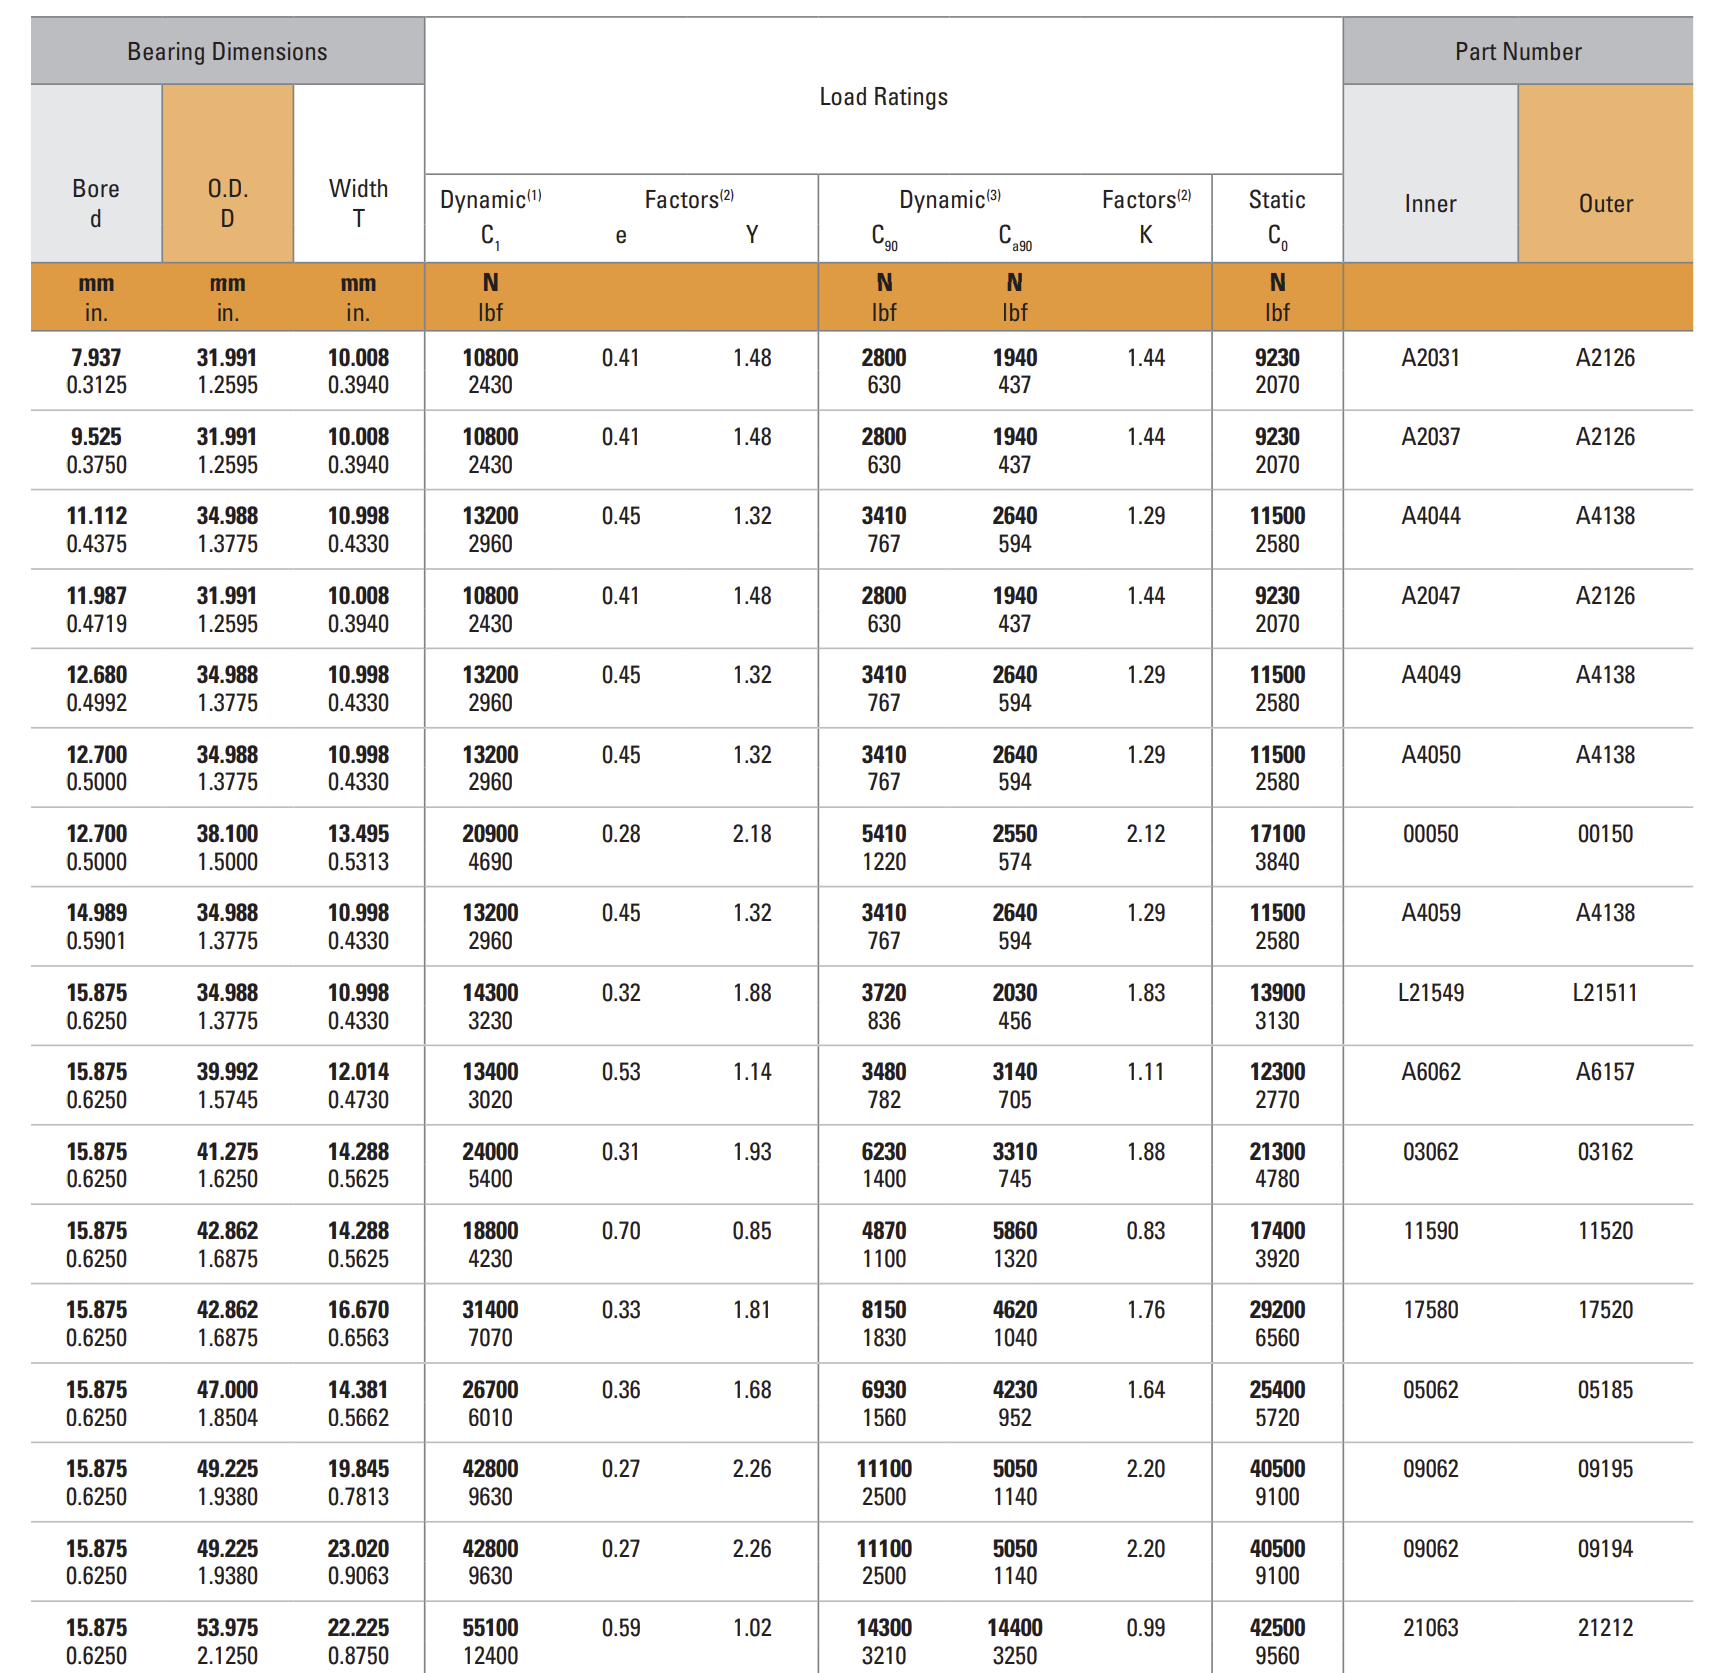

## Key Selection

This was also done in matlab, the code is shown below, with the results recorded in the summary tables.

![key 1](matlab_code/Keyway_Part_1_with_Equations.JPG)

![key 2](matlab_code/Keyway_Part_2_with_Equations.JPG)